# Train a single-task regression model from scratch

In this tutorial, we train a single-task convolutional regression model to predict total coverage over ATAC-seq peaks, starting from an ATAC-seq fragment file.

In [1]:
import os
import numpy as np
import pandas as pd
import torch

## Set experiment parameters

In [2]:
experiment='tutorial_3'
if not os.path.exists(experiment):
    os.makedirs(experiment)

## Peak and fragment files

We downloaded pseudobulk scATAC data for human microglia from Corces et al. (2020): `https://www.nature.com/articles/s41588-020-00721-x`. Here, we use the `grelu.resources` module to download the fragment file and peak file from the model zoo:

In [3]:
import grelu.resources

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Download these datasets into local directories

fragment_file_dir = grelu.resources.get_artifact(
    project='microglia-scatac-tutorial', name='fragment_file').download()

peak_file_dir = grelu.resources.get_artifact(
    project='microglia-scatac-tutorial', name='peak_file').download()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: anony-mouse-180959755991866352. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact fragment_file:latest, 2203.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:4.0
wandb:   1 of 1 files downloaded.  


In [7]:
# Paths to files
frag_file = os.path.join(fragment_file_dir, "Microglia_full.bed")
peak_file = os.path.join(peak_file_dir, "Microglia_full_peaks.narrowPeak")

## Set parameters

In [4]:
seq_len=2114 # Length of the input sequence
label_len=1000 # Length over which we calculate total coverage
val_chroms=["chr10"]
test_chroms=["chr11"]
genome="hg38"

## Read peak file

We read peak coordinates from the narrowPeak file.

In [8]:
import grelu.io.bed

peaks = grelu.io.bed.read_narrowpeak(peak_file)
peaks.tail(3)

,chrom,start,end,name,score,strand,signal,pvalue,qvalue,summit
83316,chrY,56870777,56870983,Microglia_full_peak_83318,94,.,3.83352,11.58170,9.41381,116
83317,chrY,56873629,56873811,Microglia_full_peak_83319,49,.,3.01171,7.02098,4.99754,105
83318,chrY,56874075,56874225,Microglia_full_peak_83320,42,.,2.86533,6.19767,4.20704,17


## Summit-center peaks

We extract the genomic coordinates for the 2114 bases surrounding the summit of each peak.

In [9]:
import grelu.data.preprocess

peaks = grelu.data.preprocess.extend_from_coord(
    peaks,
    seq_len=seq_len,
    center_col="summit"
)
peaks.tail(3)

,chrom,start,end
83316,chrY,56869836,56871950
83317,chrY,56872677,56874791
83318,chrY,56873035,56875149


## Filter peaks

We filter the peaks to include only those within autosomes. You can also use "autosomesX" or "autosomesXY" to include sex chromosomes.

In [10]:
peaks = grelu.data.preprocess.filter_chromosomes(peaks, 'autosomes')

Keeping 80823 intervals


We drop peaks that are close to ENCODE hg38 blacklist regions.

In [11]:
peaks = grelu.data.preprocess.filter_blacklist(
    peaks,
    genome=genome,
    window=50 # Remove peaks if they are within 50 bp of a blacklist region
)

Keeping 80028 intervals


## Get GC matched negative regions

To ensure that the model also learns to recognize regions that are not peaks, we will include a set of "negative" (non-peak) regions with similar GC content to the peaks.

In [12]:
negatives = grelu.data.preprocess.get_gc_matched_intervals(
    peaks,
    binwidth=0.02, # resolution of measuring GC content
    genome=genome,
    chroms="autosomes", # negative regions will also be chosen from autosomes
    #gc_bw_file='gc_hg38_2114.bw',
    blacklist=genome, # negative regions overlapping the blacklist will be dropped
    seed=0,
)
negatives.head(3)

Extracting matching intervals
Filtering blacklist
Keeping 77148 intervals


,chrom,start,end
39048,chr1,801206,803320
13936,chr1,813890,816004
20216,chr1,858284,860398


We can visualize a histogram of GC content in the peaks and negative regions to verify that they are similar.

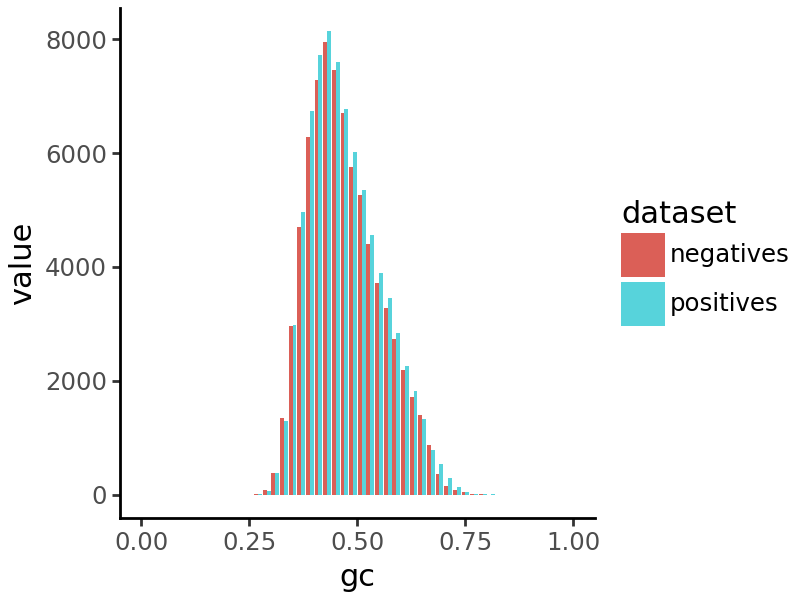

In [13]:
import grelu.visualize
grelu.visualize.plot_gc_match(
    positives=peaks, negatives=negatives, binwidth=0.02, genome="hg38", figsize=(4, 3)
)

## Combine peaks and negative regions

The full dataset includes both peaks and negative regions.

In [14]:
regions = pd.concat([peaks, negatives])
len(regions)

157176

## Make BigWig file

We convert the ATAC-seq fragment file into a bigWig file which contains the number of Tn5 insertions at each position.

In [14]:
bw_file = grelu.data.preprocess.make_insertion_bigwig(
    frag_file = frag_file,
    plus_shift=0,
    minus_shift=1, # This corrects the +4/-5 Tn5 shift to a +4/-4 shift
    genome=genome,
    chroms="autosomes", # The output bigWig file contains coverage over autosomes.
)

Making bedgraph file
cat /code/gReLU/docs/tutorials/artifacts/fragment_file:v0/Microglia_full.bed | awk -v OFS="\t" '{print $1,$2+0,$3,1000,0,"+";
    print $1,$2,$3+1,1000,0,"-"}' | sort -k1,1 | grep -e ^chr1 -e ^chr2 -e ^chr3 -e ^chr4 -e ^chr5 -e ^chr6 -e ^chr7 -e ^chr8 -e ^chr9 -e ^chr10 -e ^chr11 -e ^chr12 -e ^chr13 -e ^chr14 -e ^chr15 -e ^chr16 -e ^chr17 -e ^chr18 -e ^chr19 -e ^chr20 -e ^chr21 -e ^chr22  | bedtools genomecov -bg -5 -i stdin -g /root/.local/share/genomes/hg38/hg38.fa.sizes | bedtools sort -i stdin > ./Microglia_full.bedGraph
Making bigWig file
bedGraphToBigWig ./Microglia_full.bedGraph /root/.local/share/genomes/hg38/hg38.fa.sizes ./Microglia_full.bw
Deleting temporary files


## Split data by chromosome

We now split the dataset by chromosome to create separate datasets for training, validation and testing.

In [15]:
train, val, test = grelu.data.preprocess.split(
    regions, val_chroms=val_chroms, test_chroms=test_chroms)

Selecting training samples
Keeping 140654 intervals


Selecting validation samples
Keeping 8115 intervals


Selecting test samples
Keeping 8407 intervals
Final sizes: train: (126394, 3), val: (699, 3), test: (791, 3)


## Make labeled datasets

We now make pytorch dataset objects in order to load paired sequences and coverage values from the genome and the bigWig file. We use the `BigWigSeqDataset` class.

We first make the training dataset. To increase model robustness we use several forms of data augmentation here: `rc=True` (reverse complementing the input sequence), `max_seq_shift=2` (shifting the coordinates of the input sequence by upto 2 bp in either direction; also known as jitter), and `max_pair_shift=20` (shifting both the input sequence and the region for which to calculate coverage by upto 20 bp in either direction).

Further, we use `label_aggfunc="sum"` which means that the label will be the summed coverage over the central region of the interval.

In [16]:
import grelu.data.dataset

In [18]:
train_ds = grelu.data.dataset.BigWigSeqDataset(
    intervals = train,
    bw_files=[bw_file],
    label_len=label_len,
    label_aggfunc="sum",
    rc=True, # reverse complement
    max_seq_shift=2, # Shift the sequence
    max_pair_shift=20, # Shift both sequence and label
    augment_mode="random",
    seed=0,
    genome=genome,
)

We do not apply any augmentations to the validation and test datasets (although it is possible to do so).

In [19]:
val_ds = grelu.data.dataset.BigWigSeqDataset(
    intervals = val,
    bw_files=[bw_file],
    label_len=label_len,
    label_aggfunc="sum", 
    genome=genome,
)

test_ds = grelu.data.dataset.BigWigSeqDataset(
    intervals = test,
    bw_files=[bw_file],
    label_len=label_len,
    label_aggfunc="sum",
    genome=genome,
)

len(train_ds), len(val_ds), len(test_ds)

(126394, 699, 791)

## Build model

In [18]:
model_params = {
    'model_type':'DilatedConvModel',
    'crop_len':(seq_len-label_len)//2,
    'n_tasks':1,
    'channels':512,
    'n_conv':8,
}

train_params = {
    'task':'regression',
    'loss': 'poisson', # Poisson loss. Other regression loss functions are "mse" and "poisson_multinomial"
    'logger':'csv',
    'lr':1e-4,
    'batch_size':256,
    'max_epochs':10,
    'devices':0,
    'num_workers':16,
    'save_dir':experiment,
}

import grelu.lightning
model = grelu.lightning.LightningModel(model_params, train_params)

## Train model

In [19]:
# See the tutorial_3 folder for logs.
trainer = model.train_on_dataset(train_ds, val_ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            1440.1917724609375
         val_mse               228943.546875
       val_pearson          0.5351300835609436
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | DilatedConvModel | 5.6 M  | train
1 | loss         | PoissonNLLLoss   | 0      | train
2 | val_metrics  | MetricCollection | 0      | train
3 | test_metrics | MetricCollection | 0      | train
4 | transform    | Identity         | 0      | train
----------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.211    Total estimated model params size (MB)
118       Modules in train mode
0         Modules

Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 494/494 [02:11<00:00,  3.76it/s, v_num=0, train_loss_step=194.0]
Validation: |                                                                                                                                                                                                        | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 494/494 [02:13<00:00,  3.71it/s, v_num=0, train_loss_step=179.0, train_loss_epoch=177.0]
Validation: |                                                                                                                                                                                                        | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████████████████████████

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 494/494 [02:14<00:00,  3.66it/s, v_num=0, train_loss_step=111.0, train_loss_epoch=117.0]


## Load the best model version

In [20]:
best_checkpoint = trainer.checkpoint_callback.best_model_path
print(best_checkpoint)

tutorial_3/2024_06_11_05_24/version_0/checkpoints/epoch=2-step=1482.ckpt


In [21]:
model = grelu.lightning.LightningModel.load_from_checkpoint(best_checkpoint)

## Evaluate model

We now evaluate the model's performance on the test dataset.

In [22]:
test_metrics = model.test_on_dataset(
    test_ds,
    batch_size=256,
    devices=0,
    num_workers=8
)

test_metrics

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           122.24252319335938
        test_mse               105955.78125
      test_pearson           0.665069580078125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_mse,test_pearson
Microglia_full,105955.78125,0.66507


## Run inference on held out sequences

We can now get the predicted total coverage for each sequence in the test set.

In [23]:
preds = model.predict_on_dataset(
    test_ds, devices=0, num_workers=8
    )
preds.shape

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


(791, 1, 1)

We can visualize a scatter plot of predicted vs. true coverage values

/tmp/ipykernel_330092/723997811.py:3: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_pointdensity : Removed 2 rows containing non-finite values.


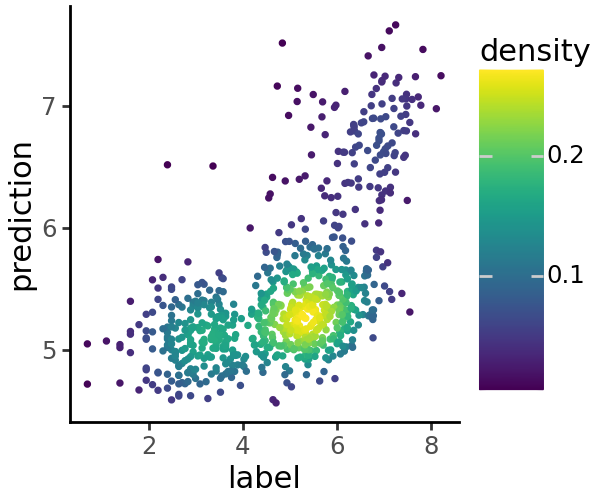

In [24]:
grelu.visualize.plot_pred_scatter(
    preds=np.log(preds),
    labels=np.log(test_ds.get_labels()),
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)